# Replicating Head et al 2017 w/ RCF features

## 0. Set up

### Imports

In [1]:
import os.path
import sys
import warnings
from pathlib import Path

import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from mosaiks.utils.imports import *
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from util import geometry, load_data
from util import replication_functions as repfun

sys.path.insert(1, "util")

idx = pd.IndexSlice

savedir = os.path.join(c.data_dir, "output", "head_rep")
os.makedirs(savedir, exist_ok=True)

sns.set(style="white", context="paper")

%matplotlib inline

### Settings

In [2]:
countries = ["rwanda", "haiti", "nepal"]

# outcomes to test
outcomes = [
    "wealth",
    "electricity",
    "mobile",
    "education",
    "bed_net_num",
    "female_bmi",
    "water",
    "height_4_age",
    "weight_4_age",
    "hemoglobin",
    "weight_4_height",
]

outcomes_pretty = [
    "Wealth",
    "Electricity",
    "Mobile Phone Ownership",
    "Education",
    "Bed net count",
    "Female BMI",
    "Water access",
    "Child height %ile",
    "Child weight %ile",
    "Hemoglobin level",
    "Child weight / height %ile",
]

# This ensures the pdf figures have text that is formatted correctly
plt.rcParams["pdf.fonttype"] = 42

num_folds = c.ml_model["n_folds"]

### ML settings
## ridge hyperparameters
# RCF
lambdas_rcf = np.logspace(-2, 6, 9)
# NL
lambdas_nl = np.append(
    np.logspace(-7, 8, 16),
    np.array([10 ** 15, 10 ** 20, 10 ** 25, 10 ** 50]),
)
# COMBINED
lambdas_hybrid_nl = np.concatenate((np.array([1e-10]), np.logspace(-5, 12, 18)))
lambdas_hybrid_rcf = np.concatenate((np.array([1e-10]), np.logspace(-5, 12, 18)))

## cross-validation splits
cv = KFold(n_splits=num_folds, shuffle=True, random_state=0)

### OUTPUT DIR
figdir = Path(c.res_dir, "figures", "FigS16")
figdir.mkdir(exist_ok=True, parents=True)
tabdir = Path(c.res_dir, "tables", "TableS6")
tabdir.mkdir(exist_ok=True, parents=True)

### Helper Functions

In [3]:
def csv_file(basename, country_name):
    return os.path.join(
        c.data_dir,
        "raw/head_rep/All_DHS",
        country_name + "_" + basename + ".csv",
    )


def read_records(metric_column, country_name, nl=False):
    if metric_column == "wealth":
        basename = "DHS_wealth"
    elif metric_column == "water":
        basename = "cluster_avg_water_nightlights"
    elif metric_column == "education":
        basename = "cluster_avg_educ_nightlights"
    else:
        basename = metric_column

    fpath = csv_file(basename, country_name)
    if nl:
        fpath = fpath.replace(".csv", "_withNL.csv")

    out = pd.DataFrame(load_data.read_records(fpath, metric_column), dtype="float64")
    out["id"] = out.id.astype("int")
    out = out.set_index("id")
    return out.drop(columns=["LATNUM", "LONGNUM"], errors="ignore")

### Data to load once
Everything below will be run once per country but this needs only to be run once. We don't actually use these but need them for the functions borrowed from Head et al. to run

In [4]:
nightlights_raster = os.path.join(
    c.data_dir,
    "raw/head_rep/nightlights/F182010.v4d_web.stable_lights.avg_vis.tif",
)
map_geometry = geometry.MapGeometry(nightlights_raster)

## 1. Define pipeline steps

### a. Load outcome data

In [5]:
def load_records(country_name, record_dir={}):
    record_dir[country_name] = {}
    for o in outcomes:
        record_dir[country_name][o] = read_records(o, country_name)
    return record_dir

### b. Load features for each location 

#### RCF features

In [6]:
def load_rcf_features(country_name, record):
    ctry = country_name.title()
    features_data_dir = Path(c.features_dir, "head_rep", ctry)

    ## Load the features (if features previously saved):
    if os.path.isfile(os.path.join(features_data_dir, "X_rcf.npy")):
        return np.load(
            os.path.join(features_data_dir, "X_rcf.npy"), allow_pickle=True
        ).astype("float64")

    ## else aggregate image features over clusters
    # Load in the features:
    features_fn = os.path.join(features_data_dir, f"{ctry}_full.pkl")
    with open(features_fn, "rb") as f:
        meta = dill.load(f)

    names = meta["names"]
    features_ours = meta["X"]
    meta["X"].shape

    X_rcf, records_to_discard = repfun.get_features_for_clusters(
        record, map_geometry=map_geometry, X=features_ours, names=names
    )

    np.save(os.path.join(features_data_dir, "X_rcf.npy"), X_rcf)
    np.save(
        os.path.join(features_data_dir, "records_to_discard.npy"), records_to_discard
    )
    return X_rcf

#### Nightlight features

In [7]:
def load_nl_features(country_name):
    # Load in nightlight values, which we've attached to the wealth file.
    # They are the same for all outcomes, so just using wealth
    records_NL = read_records("wealth", country_name, nl=True)

    # Get the nl values from this file. The bins start at `bin4` for some reason
    NLbins = [("NLbin" + str(binNum)) for binNum in range(4, 25)]
    NLcols = ["NLmean", "NLmax", "NLmin"] + NLbins
    NL_df = records_NL[NLcols]
    return NL_df.values, NL_df

#### Drop any observations with missing data

In [8]:
def get_ys(records, nl_df):
    # Count and drop observations where latitude and longitude are missing
    # (coded as 0, 0)
    ys = pd.DataFrame()
    for r in records.keys():
        records[r] = records[r][
            (records[r].latitude != 0) & (records[r].longitude != 0)
        ]
        ys[r] = records[r][r]

    # make sure indices are matched
    assert (ys.index == nl_df.index).all()
    return ys


def drop_missing(ys, X_rcf, X_nl):
    valid = ys.notnull().all(axis=1).values
    X_rcf = X_rcf[valid]
    X_nl = X_nl[valid]
    ys = ys[valid]
    return ys, X_rcf, X_nl

### c. Solve

In [9]:
def get_r2s(X, y, lambdas, fit_intercept=True, normalize=True, suffix=""):

    # cast to array
    lambdas = np.array(lambdas)

    r2s_by_fold_by_label = np.zeros(
        (num_folds, y.shape[1], len(lambdas)), dtype="float64"
    )
    for lx, l in enumerate(lambdas):
        reg = Ridge(alpha=l, fit_intercept=fit_intercept, normalize=normalize)
        for ix, (train_ix, val_ix) in enumerate(cv.split(X)):
            reg.fit(X[train_ix], y.values[train_ix])
            r2s_by_fold_by_label[ix, :, lx] = r2_score(
                y.values[val_ix], reg.predict(X[val_ix]), multioutput="raw_values"
            )
    mean_r2 = r2s_by_fold_by_label.mean(axis=0)
    best_lambda_idxs = mean_r2.argmax(axis=1)
    best_lambdas = lambdas[best_lambda_idxs]
    best_r2s = np.array(
        [r2s_by_fold_by_label[:, i, best_lambda_idxs[i]] for i in range(ys.shape[1])]
    ).T

    return xr.Dataset(
        data_vars={
            "r2"
            + suffix: (("fold", "outcome", "lambda" + suffix), r2s_by_fold_by_label),
            "best_lambda_idx" + suffix: (("outcome",), best_lambda_idxs),
            "best_lambda" + suffix: (("outcome",), best_lambdas),
            "best_r2" + suffix: (("fold", "outcome"), best_r2s),
        },
        coords={
            "fold": range(num_folds),
            "outcome": outcomes,
            "lambda" + suffix: lambdas,
        },
    )


def cv_hybrid(X_rcf, X_nl, ys, lambdas_rcf, lambdas_nl, fit_intercept=False):
    results_hybrid = []
    for ln in lambdas_nl:
        results_this_nl = []
        for lr in lambdas_rcf:
            l = lr / ln
            this_nl = X_nl * np.sqrt(l)
            this_X = np.concatenate((X_rcf, this_nl), axis=1)
            out = get_r2s(
                this_X,
                ys,
                [lr],
                fit_intercept=fit_intercept,
                normalize=False,
                suffix="_hyb_rcf",
            )
            out = out.drop([v for v in out.variables if v.startswith("best_")])
            results_this_nl.append(out)
        results_hybrid.append(xr.concat(results_this_nl, dim="lambda_hyb_rcf"))
    r = xr.concat(
        results_hybrid, dim=pd.Index(lambdas_nl, name="lambda_hyb_nl")
    ).rename({"r2_hyb_rcf": "r2_hyb"})

    # now aggregate across ratios
    r["best_lambda_idx_hyb_nl"] = (
        r.r2_hyb.mean(dim="fold").max(dim="lambda_hyb_rcf").argmax("lambda_hyb_nl")
    )
    r["best_lambda_idx_hyb_rcf"] = (
        r.r2_hyb.mean(dim="fold").max(dim="lambda_hyb_nl").argmax("lambda_hyb_rcf")
    )
    r["best_lambda_hyb_nl"] = r.lambda_hyb_nl[r.best_lambda_idx_hyb_nl]
    r["best_lambda_hyb_rcf"] = r.lambda_hyb_rcf[r.best_lambda_idx_hyb_rcf]
    r["best_r2_hyb"] = r.r2_hyb.isel(
        lambda_hyb_nl=r.best_lambda_idx_hyb_nl, lambda_hyb_rcf=r.best_lambda_idx_hyb_rcf
    )
    return r


def gen_results_ds(lambdas_rcf, lambdas_nl, lambdas_hybrid_rcf, lambdas_hybrid_nl):
    coords = {
        "lambda_rcf": lambdas_rcf,
        "lambda_nl": lambdas_nl,
        "lambda_hyb_nl": lambdas_hybrid_nl,
        "lambda_hyb_rcf": lambdas_hybrid_rcf,
        "intercept": [False, True],
        "fold": range(num_folds),
        "outcome": outcomes,
    }
    return xr.Dataset(coords)


def evaluate_hp_search_params(results_ds, intercept=True):
    evaluate = results_ds.sel(intercept=intercept)

    def eval_lam(idx_var, lambda_var, r2_var):
        val_min = evaluate[idx_var].min(dim=["country"])
        val_max = evaluate[idx_var].max(dim=["country"])
        hit_max = (
            evaluate.sel(outcome=val_max == (len(evaluate[lambda_var]) - 1))[r2_var]
            .mean(dim=["fold"])
            .min(dim=["country"])
            .shape[0]
        )
        hit_min = (
            evaluate.sel(outcome=val_min == 0)[r2_var]
            .mean(dim=["fold"])
            .min(dim=["country"])
            .shape[0]
        )
        return hit_min, hit_max

    rcf_min, rcf_max = eval_lam("best_lambda_idx_rcf", "lambda_rcf", "best_r2_rcf")
    nl_min, nl_max = eval_lam("best_lambda_idx_nl", "lambda_nl", "best_r2_nl")
    hyb_nl_min, hyb_nl_max = eval_lam(
        "best_lambda_idx_hyb_nl", "lambda_hyb_nl", "best_r2_hyb"
    )
    hyb_rcf_min, hyb_rcf_max = eval_lam(
        "best_lambda_idx_hyb_rcf", "lambda_hyb_rcf", "best_r2_hyb"
    )

    if rcf_min != 0:
        print("Lambda RCF hitting min")
    if rcf_max != 0:
        print("Lambda RCF hitting max")
    if nl_min != 0:
        print("Lambda NL hitting min")
    if nl_max != 0:
        print("Lambda NL hitting max")
    if hyb_nl_min != 0:
        print("Lambda hyb NL hitting min")
    if hyb_nl_max != 0:
        print("Lambda hyb NL hitting max")
    if hyb_rcf_min != 0:
        print("Lambda hyb RCF hitting min")
    if hyb_rcf_max != 0:
        print("Lambda hyb RCF hitting max")

### d. Load in Head Rep Values

In [10]:
def load_head_results(country_name):
    head_name_map = {
        "mobile phone ownership": "mobile",
        "child height percentile": "height_4_age",
        "child weight percentile": "weight_4_age",
        "child weight / height percentile": "weight_4_height",
        "hemoglobin level": "hemoglobin",
        "bed net count": "bed_net_num",
        "female BMI": "female_bmi",
    }

    def fix_name(x):
        out = x.rstrip()
        try:
            return head_name_map[out]
        except KeyError:
            return out

    headFN = os.path.join(
        c.data_dir,
        "raw",
        "head_rep",
        "head_R2",
        country_name + "_" + "block5.txt",
    )
    res = pd.read_csv(headFN, delimiter="\t")
    res["Metric"] = res["Metric"].apply(fix_name)
    res = res.drop(columns=["Test Index"])
    res = res.rename(
        columns={"Metric": "outcome", "Fold Index": "fold", "Score": "r2_head"}
    )
    res = res.set_index(["fold", "outcome"])
    res = res.to_xarray()["r2_head"]
    return res

## 2. Run pipeline steps for all countries

In [11]:
records = {}
results = []

for country_name in countries:

    print(country_name)

    # initialize results array
    this_results = gen_results_ds(
        lambdas_rcf, lambdas_nl, lambdas_hybrid_rcf, lambdas_hybrid_nl
    )

    ## load data
    records = load_records(country_name, records)
    X_rcf = load_rcf_features(country_name, records[country_name]["wealth"])
    X_nl, nl_df = load_nl_features(country_name)
    ys = get_ys(records[country_name], nl_df)
    ys, X_rcf, X_nl = drop_missing(ys, X_rcf, X_nl)

    ## solve
    # RCF and NL
    for i in ((X_rcf, lambdas_rcf, "_rcf"), (X_nl, lambdas_nl, "_nl")):
        print(f"...running {i[2][1:]} model")
        res_lst = []
        for intercept in [False, True]:
            # avoid ill-conditioned warnings
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                res_lst.append(
                    get_r2s(
                        i[0],
                        ys,
                        i[1],
                        fit_intercept=intercept,
                        normalize=False,
                        suffix=i[2],
                    )
                )
        res = xr.concat(res_lst, dim="intercept")
        res["intercept"] = [False, True]
        for v in res.data_vars:
            this_results[v] = res[v]
    # hybrid
    res_lst = []
    print("...running hybrid model")
    for intercept in [False, True]:
        # avoid ill-conditioned warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res_lst.append(
                cv_hybrid(
                    X_rcf,
                    X_nl,
                    ys,
                    lambdas_hybrid_rcf,
                    lambdas_hybrid_nl,
                    fit_intercept=intercept,
                )
            )
    res = xr.concat(res_lst, dim="intercept")
    res["intercept"] = [False, True]
    for v in res.data_vars:
        this_results[v] = res[v]

    # head
    this_results["r2_head"] = load_head_results(country_name)
    results.append(this_results)

results_ds = xr.concat(results, dim="country")
results_ds["country"] = countries

# see which lambdas hit upper or lower bounds
evaluate_hp_search_params(results_ds, True)

rwanda
...running rcf model
...running nl model
...running hybrid model
haiti
...running rcf model
...running nl model
...running hybrid model
nepal
...running rcf model
...running nl model
...running hybrid model
Lambda hyb NL hitting max
Lambda hyb RCF hitting max


## 3. Diagnostics on results

Here we evaluate whether the cases where the hyperparameter has hit the upper or lower bound of the search grid. The question is whether the performance is indeed meaningfully still improving at the edge of the search space, or if we have realistically hit an asymptote in improved performance. First, we evaluate the regularization parameter on the nightlights data, which is hitting both the upper and lower bounds for some outcome-country combinations.

In [12]:
def hyb_eval_plot(results_ds, idx_var, lambda_var, r2_var, intercept=True):
    evaluate = results_ds.sel(intercept=intercept)
    val_min = evaluate[idx_var].min(dim=["country"])
    val_max = evaluate[idx_var].max(dim=["country"])
    hit_max = evaluate.sel(outcome=val_max == (len(evaluate[lambda_var]) - 1))[
        r2_var
    ].mean(dim=["fold"])
    hit_min = evaluate.sel(outcome=val_min == 0)[r2_var].mean(dim=["fold"])

    if len(hit_min.outcome):
        plt.figure()
        for ctry in hit_min.country:
            hit_min.sel(country=ctry).max("lambda_hyb_rcf").plot(hue="outcome")
        plt.xscale("log")
        plt.title("Lower bound")
    if len(hit_max.outcome):
        plt.figure()
        for ctry in hit_max.country:
            hit_max.sel(country=ctry).max("lambda_hyb_rcf").plot(hue="outcome")
        plt.xscale("log")
        plt.title("Upper bound")
    return plt.gcf(), plt.gca()

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Upper bound'}, xlabel='lambda_hyb_nl', ylabel='r2_hyb'>)

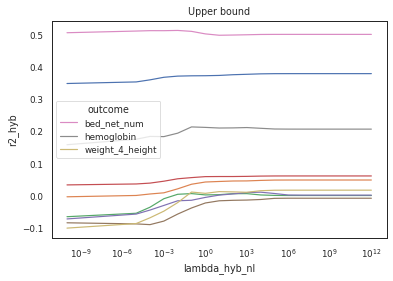

In [13]:
hyb_eval_plot(results_ds, "best_lambda_idx_hyb_nl", "lambda_hyb_nl", "r2_hyb")

For both the outcome-country pairs hitting the lower edge of the search grid for the NL regularization and those hitting the upper edge, performance really has asymptoted and we do not need to expand the search space further.

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Upper bound'}, xlabel='lambda_hyb_nl', ylabel='r2_hyb'>)

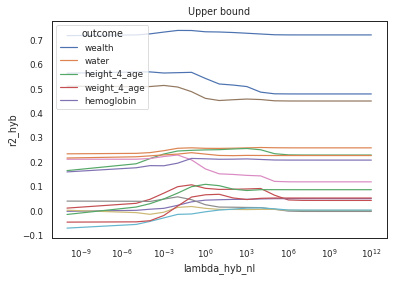

In [14]:
hyb_eval_plot(results_ds, "best_lambda_idx_hyb_rcf", "lambda_hyb_rcf", "r2_hyb")

It appears the same is true for the outcome-country pairs that are hitting the upper edge of the search space for the RCF regularization parameter

In [15]:
# save
results_ds.to_netcdf(os.path.join(savedir, "head_rep_performance.nc"))

## 4. Plots

In [16]:
# get the records we want to plot
plot_ds = results_ds[["best_r2_rcf", "best_r2_nl", "best_r2_hyb"]]

# confirm that intercept is better than no-intercept in general
# and then use results w/ intercept
mean_perf = plot_ds.mean(dim=["country", "outcome", "fold"])
assert (mean_perf.sel(intercept=True) >= mean_perf.sel(intercept=False)).all()
plot_ds = plot_ds.sel(intercept=True).drop("intercept").squeeze()

# add in head results
plot_ds["best_r2_head"] = results_ds["r2_head"]

plot_df = plot_ds.to_dataframe().rename(
    columns={
        "best_r2_rcf": "MOSAIKS (RCF)",
        "best_r2_nl": "Nighttime lights",
        "best_r2_hyb": "MOSAIKS (RCF + nighttime lights)",
        "best_r2_head": "Head et al., 2017 (transfer learning)",
    }
)
plot_df.columns.name = "method"
plot_ser = plot_df.stack()
plot_ser.name = "r2"
plot_df = plot_ser.reset_index(drop=False)
plot_df["outcome"] = plot_df["outcome"].map(
    lambda x: outcomes_pretty[outcomes.index(x)]
)

In [17]:
# We report in the main text the average difference in R2 between MOSAIKS and transfer learning for Nepal only
nepal = plot_ds.loc[dict(country="nepal")]
nepal = nepal.assign(delta_r2=nepal["best_r2_head"] - nepal["best_r2_hyb"])
print(
    f"Mean difference in R2 between Head et al. and MOSAIKS in Nepal is: {np.mean(nepal['delta_r2']).item():.3f}"
)

Mean difference in R2 between Head et al. and MOSAIKS in Nepal is: 0.080


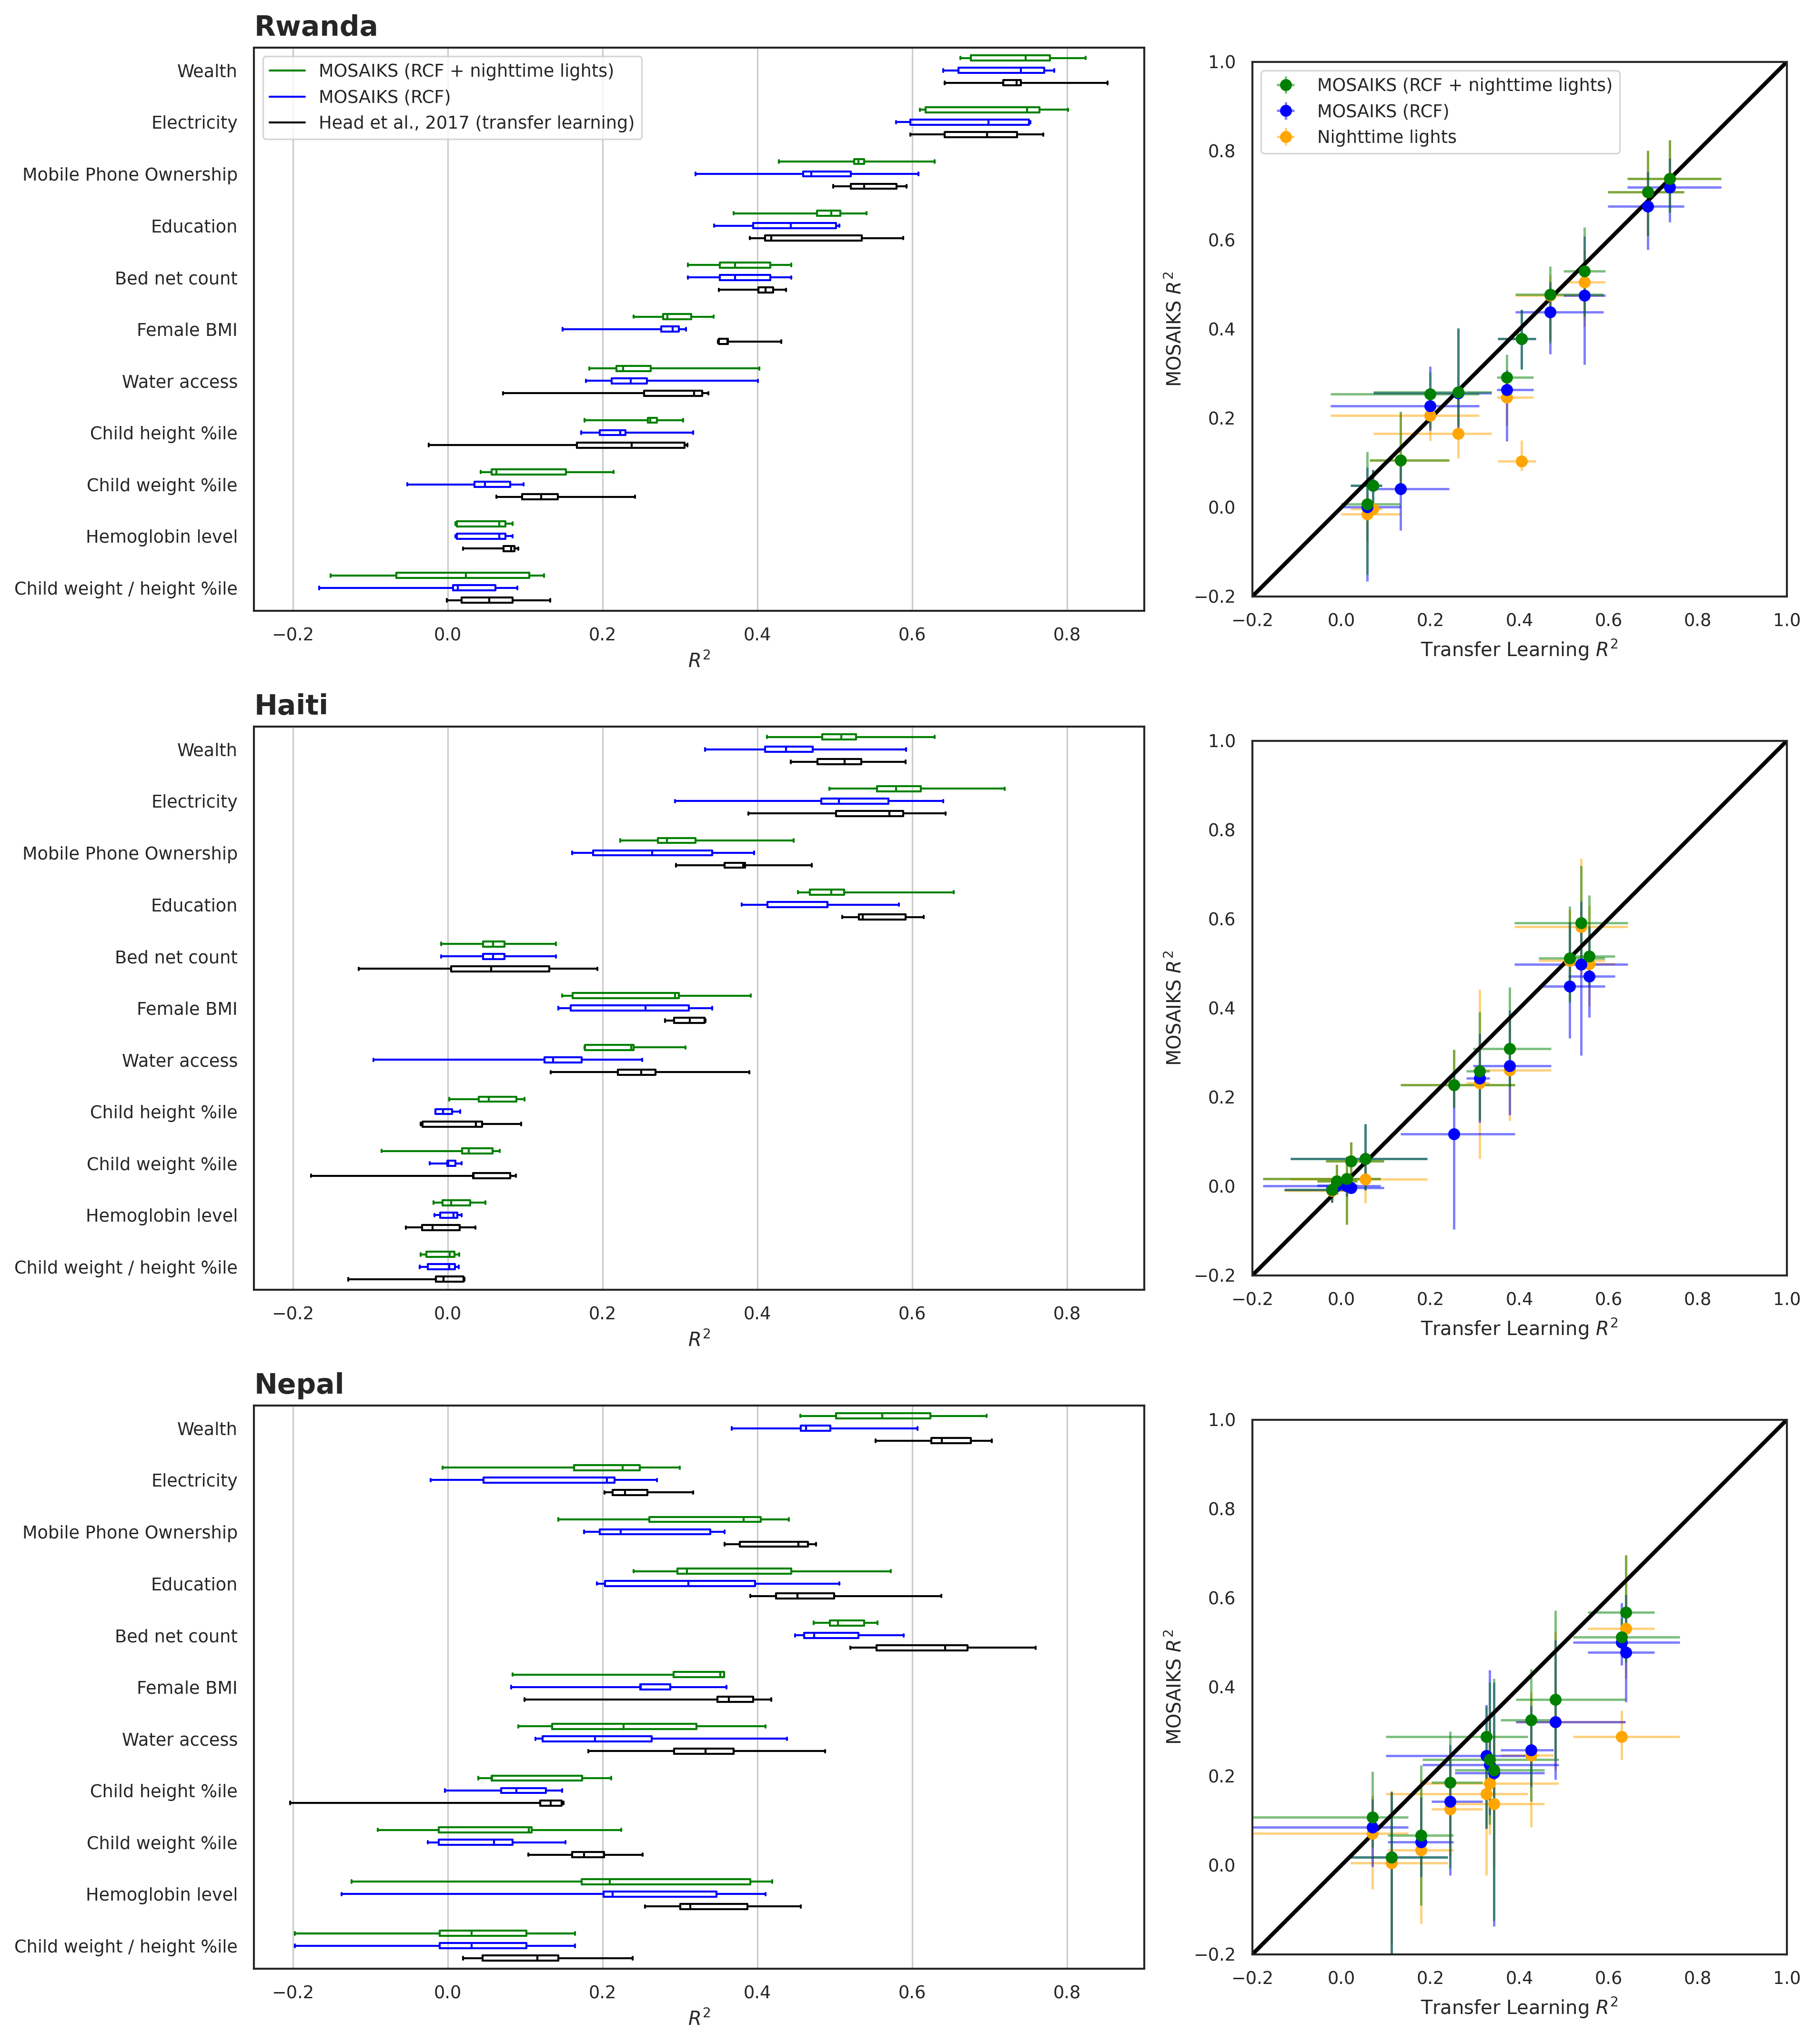

In [18]:
fig, axs = plt.subplots(
    3,
    2,
    figsize=(12.8, 14.4),
    dpi=300,
    gridspec_kw={"width_ratios": [1.666, 1]},
    tight_layout=True,
)

colors = {
    "MOSAIKS (RCF)": "blue",
    "Nighttime lights": "orange",
    "MOSAIKS (RCF + nighttime lights)": "green",
    "Head et al., 2017 (transfer learning)": "black",
}
mult = 5


def set_elements(object, color):
    for e in ["boxes", "whiskers", "fliers", "means", "medians", "caps"]:
        plt.setp(object[e], color=color)


def restack_df(plot_df, method):
    out = (
        plot_df.loc[this_plot["method"] == method, ["fold", "outcome", "r2"]]
        .set_index(["fold", "outcome"])
        .unstack(["outcome"])
    )
    out.columns = out.columns.droplevel(0)
    return out.reindex(columns=outcomes_pretty[-1::-1])


for cx, country_name in enumerate(countries):

    ## barplot
    this_plot = plot_df.loc[plot_df["country"] == country_name, :].drop(
        columns="country"
    )
    ax = axs[cx, 0]

    # Head
    bp_head = ax.boxplot(
        restack_df(this_plot, "Head et al., 2017 (transfer learning)"),
        positions=mult * np.arange(len(outcomes)),
        whis=[0, 100],
        labels=[""] * len(outcomes),
        vert=False,
    )

    # RCF
    bp_rcf = ax.boxplot(
        restack_df(this_plot, "MOSAIKS (RCF)"),
        positions=mult * np.arange(len(outcomes)) + 1.2,
        whis=[0, 100],
        labels=restack_df(this_plot, "MOSAIKS (RCF)").columns,
        vert=False,
    )

    # Hybrid
    bp_hyb = ax.boxplot(
        restack_df(this_plot, "MOSAIKS (RCF + nighttime lights)"),
        positions=mult * np.arange(len(outcomes)) + 2.4,
        whis=[0, 100],
        labels=[""] * len(outcomes),
        vert=False,
    )

    # fix up plot config
    set_elements(bp_head, "black")
    set_elements(bp_rcf, "blue")
    set_elements(bp_hyb, "green")
    ax.set_xticks(np.linspace(-0.2, 0.8, num=6))
    ax.grid("major", axis="x")
    ax.set_xlim(-0.25, 0.9)
    ax.set_ylim(ax.get_ylim()[0] - 0.5, ax.get_ylim()[1] + 0.5)
    ax.set_xlabel("$R^2$")

    # Labels
    ax.set_title(
        country_name.title(),
        loc="left",
        fontdict={"fontsize": 14, "fontweight": "bold"},
    )

    axs[0, 0].legend(
        [bp_hyb["boxes"][0], bp_rcf["boxes"][0], bp_head["boxes"][0]],
        [
            "MOSAIKS (RCF + nighttime lights)",
            "MOSAIKS (RCF)",
            "Head et al., 2017 (transfer learning)",
        ],
        loc="upper left",
    )

    ## scatterplot
    if cx:
        legend = False
    else:
        legend = "brief"
    head_ser = this_plot[this_plot.method == "Head et al., 2017 (transfer learning)"]
    head_ser = head_ser.groupby(["outcome", "method"]).r2
    head_mean = head_ser.mean()
    head_minmax = pd.DataFrame(head_mean - head_ser.min()).join(
        head_ser.max() - head_mean, lsuffix="min", rsuffix="max"
    )

    other_ser = this_plot[this_plot.method != "Head et al., 2017 (transfer learning)"]
    r2_ser = other_ser.groupby(["outcome", "method"]).r2
    mean_ser = r2_ser.mean()
    other_minmax = pd.DataFrame(mean_ser - r2_ser.min()).join(
        r2_ser.max() - mean_ser, lsuffix="min", rsuffix="max"
    )

    ax = axs[cx, 1]
    with sns.plotting_context(rc={"lines.markersize": 10}):
        for mx, method in enumerate(
            ("Nighttime lights", "MOSAIKS (RCF)", "MOSAIKS (RCF + nighttime lights)")
        ):
            markers, caps, bars = ax.errorbar(
                head_mean,
                mean_ser.loc[idx[:, method]],
                xerr=head_minmax.T.values,
                yerr=other_minmax.loc[idx[:, method], :].T.values,
                ls="none",
                color=colors[method],
                alpha=1,
                label=method,
                fmt=".",
            )
            # set transparent bars
            [bar.set_alpha(0.5) for bar in bars]
    ax.plot([-0.2, 1], [-0.2, 1], color="black", linewidth=2)
    ax.set_xlabel("Transfer Learning $R^2$")
    ax.set_ylabel("MOSAIKS $R^2$")
    ax.set_xlim(-0.2, 1)
    ax.set_ylim(-0.2, 1)
    ax.set_aspect("equal", "box")


# right plot legend
# reverse order to match left plot
ax = axs[0, 1]
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc="upper left")

In [19]:
# save
fig.savefig(
    figdir / "head_rep.pdf",
    dpi="figure",
    format="pdf",
)